## Converting a .vti (VTK) Dataset to .iau

One of the functions of image-analysis-util is its ability to convert data from multiple formats into a generalized format, an .iau file. This file type is essentially an HDF5 file with a program-specific format. This demo will show how to convert .vti (Paraview VTK Image data) files into the .iau format for both 3D and 4D datasets.

In [1]:
import h5py # Creating .iau
from matplotlib import colors
from matplotlib import pyplot as plt
import os 
import numpy as np
import vtk # Reading data from .vti
from vtk.util import numpy_support as npSup # type: ignore

### .iau Components

This information is stored in an .iau file:

- dataset (3D/4D numpy array)
- axis coordinates: A 1D numpy array for each axis
- axis labels: A string label for each dimension
- metadata: A dictionary of all additional information (.vti files do not store metadata)

### 3D Datasets

.vti files store data for three dimensions, so we will read data from a single file.

In [2]:
def loadVTIDataSource(file_path):

    # Reads the VTK XML ImageData file format
    data_reader = vtk.vtkXMLImageDataReader()
    data_reader.SetFileName(file_path)
    data_reader.Update()

    raw_data = data_reader.GetOutput()
    dimensions = list(raw_data.GetDimensions())
    
    data = npSup.vtk_to_numpy(raw_data.GetPointData().GetArray('Scalars_'))
    data = data.reshape(dimensions)
    
    origin = raw_data.GetOrigin() # First point for each axis
    spacing = raw_data.GetSpacing() # Space between points for each axis
    extent = raw_data.GetExtent() # First and last index of each axis

    axis_0, axis_1, axis_2 = [], [], []

    # Adds values to each axis accordingly
    for point in range(extent[0], extent[1] + 1):
        axis_0.append(origin[0] + point * spacing[0])
    for point in range(extent[2], extent[3] + 1):
        axis_1.append(origin[1] + point * spacing[1])
    for point in range(extent[4], extent[5] + 1):
        axis_2.append(origin[2] + point * spacing[2])

    # A list of lists of varying lengths
    axes = [axis_0, axis_1, axis_2]

    return data, axes


Sample data can be found in the "`demos/files`" directory. The dimension labels used are hardcoded below.

File Path: ./files/scan40.vti
Dataset Shape: (200, 200, 200)


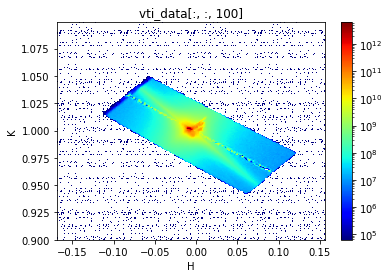

In [3]:
vti_file_path = "./files/scan40.vti"

# vti_data: 3D numpy array
# vti_axis: 2D list of lists
vti_data, vti_axes = loadVTIDataSource(vti_file_path)
axis_labels = ["H", "K", "L"]

# Info from vti file
print(f"File Path: {vti_file_path}")
print(f"Dataset Shape: {vti_data.shape}")

# Slice from vti file
vti_plot = plt.imshow(vti_data[:, :, 100], cmap="jet", norm=colors.LogNorm(), aspect="auto", 
    extent=(vti_axes[0][0], vti_axes[0][-1], vti_axes[1][0], vti_axes[1][-1]))
plt.title("vti_data[:, :, 100]")
plt.xlabel(axis_labels[0])
plt.ylabel(axis_labels[1])
plt.colorbar()

The next step is to create an HDF5 file with the extension ".iau".

In [4]:
iau_file_path = "./files/scan40.iau"

iau_file = h5py.File(iau_file_path, 'a')
iau_file.create_dataset("data", data=vti_data)
iau_file.create_group("axes")

# Loops through dimensions to add axis label, dimension scale
for i in range(len(vti_axes)):

    # Converts list to numpy array
    axis = np.array(vti_axes[i])

    iau_file.create_dataset(f"axes/axis_{i}", data=axis)

    # Adds proper label to axis
    iau_file["data"].dims[i].label = axis_labels[i]

    # Creates a dimension scale for dataset from axis points
    iau_file[f"axes/axis_{i}"].make_scale(axis_labels[i])
    iau_file["data"].dims[i].attach_scale(iau_file[f"axes/axis_{i}"])

File Path: ./files/scan40.iau
Dataset Shape: (200, 200, 200)


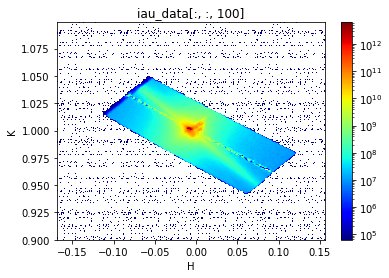

In [5]:
# Info from iau file
print(f"File Path: {iau_file_path}")
print(f"Dataset Shape: {iau_file['data'][...].shape}")

iau_data = iau_file["data"]
axis_0 = iau_file["data"].dims[0][0][:]
axis_1 = iau_file["data"].dims[1][0][:]
axis_0_label = iau_file["data"].dims[0].label
axis_1_label = iau_file["data"].dims[1].label

# Slice from iau file
iau_plot = plt.imshow(iau_data[:, :, 100], cmap="jet", norm=colors.LogNorm(), aspect="auto", 
    extent=(axis_0[0], axis_0[-1], axis_1[0], axis_1[-1]))
plt.title("iau_data[:, :, 100]")
plt.xlabel(axis_0_label)
plt.ylabel(axis_1_label)
plt.colorbar()

iau_file.close()

### 4D Datasets

This process can be replicated for a directory of multiple .vti files, which hold 3D datasets, to create a 4D dataset.

In [8]:
directory = "./files"
vti_file_list = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(".vti")]
vti_file_list.sort()
print(vti_file_list)

['./files/scan40.vti', './files/scan41.vti', './files/scan42.vti']


In [18]:
vti_data_list = [] # List of datasets from each .vti file
vti_axes = None
vti_axis_3 = [300, 250, 200] 
axis_labels = ["H", "K", "L", "V"]

for file in vti_file_list:
    vti_data, vti_axes = loadVTIDataSource(file)
    vti_data_list.append(vti_data)

full_vti_data = np.stack(vti_data_list, axis=-1)
vti_axes = [vti_axes[0], vti_axes[1], vti_axes[2], vti_axis_3]


In [22]:
iau_file_path = "./files/scans40-42.iau"

iau_file = h5py.File(iau_file_path, 'a')
iau_file.create_dataset("data", data=full_vti_data)
iau_file.create_group("axes")

# Loops through dimensions to add axis label, dimension scale
for i in range(len(vti_axes)):

    # Converts list to numpy array
    axis = np.array(vti_axes[i])

    iau_file.create_dataset(f"axes/axis_{i}", data=axis)

    # Adds proper label to axis
    iau_file["data"].dims[i].label = axis_labels[i]

    # Creates a dimension scale for dataset from axis points
    iau_file[f"axes/axis_{i}"].make_scale(axis_labels[i])
    iau_file["data"].dims[i].attach_scale(iau_file[f"axes/axis_{i}"])

In [23]:
# Info from vti file
print(f"File Path: {iau_file_path}")
print(f"Dataset Shape: {iau_file['data'].shape}")

File Path: ./files/scans40-42.iau
Dataset Shape: (200, 200, 200, 3)
